In [2]:
import anndata as ad
import scanpy as sc
from sklearn.model_selection import train_test_split
import pylab as pl
import seaborn as sns
from limix_core.util.preprocess import gaussianize, regressOut
import scipy.stats as st

from sklearn.impute import SimpleImputer
import scipy.linalg as la
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from os.path import join
from mtgwas import VCTEST
from mtgwas.utils import df_match

In [3]:
import sys
print(sys.executable)

/Users/dennyal/miniforge3/envs/tcf7l2/bin/python


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
tissue = 'Organoid'
outdir = f'visualization/{tissue}'
os.makedirs(outdir, exist_ok=True)

In [6]:
#Reading the anndata
hfile = f"../../organoid_anndata.h5ad"
idata = ad.read_h5ad(hfile)

/Users/dennyal/miniforge3/envs/tcf7l2/lib/python3.13/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [7]:
idata.obs['edit_id']

0        WT/WT
1        WT/WT
2        WT/WT
3        WT/WT
4           TT
         ...  
34195       TT
34196       TT
34197       TT
34198       CT
34199       CT
Name: edit_id, Length: 34200, dtype: category
Categories (5, object): ['-/-', 'CT', 'TT', 'WT/-', 'WT/WT']

In [8]:
idata.obs["DayEdit"] = idata.obs['edit_id'].astype('string') + idata.obs['Day'].astype('string')
idata.obs

,Day,Well,Well literal,Sample_barcode,Plate,Cell_density,Run_ID,path,SampleBarcode,edit_id,DayEdit
0,15,r03c03,C3,AS0033-02-MMR-001,101,40k,NIHB120,/data/Collinslab/tcf7l2/nyscf-organoid-images-...,AS0033-02-MMR-001,WT/WT,WT/WT15
1,15,r03c04,C4,AS0033-02-MMR-001,101,40k,NIHB120,/data/Collinslab/tcf7l2/nyscf-organoid-images-...,AS0033-02-MMR-001,WT/WT,WT/WT15
2,15,r03c05,C5,AS0051-03-MCS-001,101,40k,NIHB120,/data/Collinslab/tcf7l2/nyscf-organoid-images-...,AS0051-03-MCS-001,WT/WT,WT/WT15
3,15,r03c06,C6,AS0051-03-MCS-001,101,40k,NIHB120,/data/Collinslab/tcf7l2/nyscf-organoid-images-...,AS0051-03-MCS-001,WT/WT,WT/WT15
4,15,r03c07,C7,AS0009-03-MCS-007,101,40k,NIHB120,/data/Collinslab/tcf7l2/nyscf-organoid-images-...,AS0009-03-MCS-007,TT,TT15
...,...,...,...,...,...,...,...,...,...,...,...
34195,31,r16c19,P19,AS0051-03-MCS-008,102,40k,NIHB127,/data/Collinslab/tcf7l2/nyscf-organoid-images-...,AS0051-03-MCS-008,TT,TT31
34196,31,r16c20,P20,AS0051-03-MCS-008,102,40k,NIHB127,/data/Collinslab/tcf7l2/nyscf-organoid-images-...,AS0051-03-MCS-008,TT,TT31
34197,31,r16c22,P22,AS0033-03-MCS-007,102,40k,NIHB127,/data/Collinslab/tcf7l2/nyscf-organoid-images-...,AS0033-03-MCS-007,TT,TT31
34198,31,r16c23,P23,AS0051-03-MCS-004,102,40k,NIHB127,/data/Collinslab/tcf7l2/nyscf-organoid-images-...,AS0051-03-MCS-004,CT,CT31


In [9]:
idata.obs_names = idata.obs["DayEdit"]

In [10]:
dfX = idata.to_df()
dfX = dfX.groupby(["DayEdit"]).mean()

In [11]:
dfX

Feature Name,MinDiameter_shape,MaxDiameter_shape,MeanDiameter_shape,Area_shape,Perimeter_shape,MinDiameter_um_shape,MaxDiameter_um_shape,MeanDiameter_um_shape,Area_um^2_shape,Perimeter_um_shape,...,MinDiameter_um_halo,MaxDiameter_um_halo,MeanDiameter_um_halo,Perimeter_um_halo,FormFactor_halo,Solidity_halo,Extent_halo,Eccentricity_halo,Orientation_halo,Compactness_halo
DayEdit,,,,,,,,,,,,,,,,,,,,,
-/-15,0.282864,0.281689,0.121264,0.086504,0.787935,0.282864,0.281689,0.121264,0.086504,0.787935,...,-0.194606,-0.443427,0.045668,0.027284,0.425332,0.900100,1.258196,-0.612807,-0.305845,-0.123722
-/-16,-0.110591,-0.214991,-0.178725,-0.276997,-0.165363,-0.110591,-0.214991,-0.178725,-0.276997,-0.165363,...,-0.092574,-0.058823,-0.340036,0.597180,-0.354961,0.711434,0.691525,-0.130422,0.038402,-0.118895
-/-17,0.030597,-0.057392,-0.001259,-0.074294,-0.020255,0.030597,-0.057392,-0.001259,-0.074294,-0.020255,...,0.002804,-0.037279,-0.212364,0.433546,-0.392510,0.330124,0.328230,0.061114,0.019967,-0.103455
-/-18,0.163397,0.043143,0.186762,0.139768,-0.002551,0.163397,0.043143,0.186762,0.139768,-0.002551,...,0.024596,-0.142286,-0.071445,0.385605,-0.396169,0.279248,0.369452,-0.219537,0.003215,-0.103007
-/-19,0.288356,0.262172,0.322221,0.299583,0.242130,0.288356,0.262172,0.322221,0.299583,0.242130,...,-0.176107,-0.182022,-0.165937,-0.131503,0.000352,0.259127,0.235181,-0.132379,0.032694,-0.093597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WT/WT28,-0.084806,-0.098841,-0.079487,-0.081150,-0.092374,-0.084806,-0.098841,-0.079487,-0.081150,-0.092374,...,0.166636,0.098168,0.039341,0.089518,-0.117232,-0.377989,-0.367979,0.231517,-0.013827,-0.072471
WT/WT29,-0.126068,-0.132207,-0.127219,-0.126570,-0.118500,-0.126068,-0.132207,-0.127219,-0.126570,-0.118500,...,0.162259,0.119978,0.025877,0.151446,-0.168056,-0.439934,-0.438869,0.263546,-0.007195,-0.069654
WT/WT30,-0.174667,-0.178777,-0.174498,-0.173150,-0.186768,-0.174667,-0.178777,-0.174498,-0.173150,-0.186768,...,0.201926,0.193236,0.008509,0.251598,-0.250566,-0.522472,-0.517946,0.406615,-0.019599,-0.067647


In [12]:
# Simulate a trait to visualize its direction
# snp_df = pd.DataFrame(np.random.rand(dfX.shape[0], 1))
# snp_df.index = dfX.index
trait = "MaxDiameter_shape"
snp_df = pd.DataFrame(np.asarray(dfX[trait]))
snp_df.index = dfX.index


In [13]:
X = dfX.values
y = snp_df.values
F = np.zeros((dfX.shape[0], 1))

In [14]:
#regressing out the covariates from the embeddings
yr = regressOut(y, F)
Xr = regressOut(X, F)

In [15]:
# fit variant component model
vc = VCTEST()
res = vc.fit(Xr, yr)
ystar = vc.predict_loo()

100%|██████████| 100/100 [00:00<00:00, 9656.29it/s]


In [16]:
# getting direction for each of the images
idata.obs['ystar'] = vc.predict(idata.X).ravel()

# Working on PGAN for interpolation

### Note below interpolation was done on simulated trait

In [17]:
import sys

from torchvision.utils import make_grid
import json
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor, to_pil_image
import torch
os.chdir('..')
from models.progressive_gan import ProgressiveGAN as PGAN

In [18]:
class Generator():
    
    def __init__(self, config, checkpoint, useGPU=True):
        with open(config, 'rb') as file:
            config = json.load(file)
        self.pgan = PGAN(useGPU=useGPU, storeAVG=True, **config)
        self.pgan.load(checkpoint)
        self.netG = self.pgan.netG
        self.device = self.pgan.device
        
    def forward(self, x, eps=None):
        if eps is None:
            eps = torch.randn(x.shape[0], 512)
        if type(x)==np.ndarray:
            x = torch.Tensor(x)
        if type(eps)==np.ndarray:
            eps = torch.Tensor(eps)
        x = x.to(self.device)
        eps = eps.to(self.device)
        with torch.no_grad():
            out = self.netG(eps, x).data.cpu()
            out = 0.5 * (out + 1)
            out = torch.clip(out, 0, 1)
        return out
    
def load_image_torch(path, size):
    if type(path) in [list, np.ndarray]:
        return torch.cat([load_image_torch(_, size) for _ in path])
    return pil_to_tensor(Image.open(path).resize((size, size)))[None] / 255.


def torch_imshow(x):
    pl.imshow(x.permute(1, 2, 0))

In [20]:
config = '/Users/dennyal/Desktop/repos/HistoGWAS_PGAN/PGAN/config/config_OrganoidLocal.json'
checkpoint = '/Users/dennyal/Desktop/repos/Organoid_s6_i320000.pt'
generator = Generator(config, checkpoint, useGPU=True)

here False
Average network found !


In [21]:
# Getting the top and the bottom embedding to be used for interpolation

outliers = 0.01
extreme = 0.05
q1, q2, Q1, Q2 = np.quantile(idata.obs['ystar'].values, [outliers, extreme, 1 - extreme, 1 - outliers])
Ih1 = np.logical_and(idata.obs['ystar'].values>Q1, idata.obs['ystar'].values<Q2)
Il1 = np.logical_and(idata.obs['ystar'].values>q1, idata.obs['ystar'].values<q2)

# interpolates
emb1 = idata.X[Il1].mean(0)[None]
emb2 = idata.X[Ih1].mean(0)[None]

In [22]:
emb1

array([[-2.1607661 , -2.1792958 , -2.1353388 , -1.8041557 , -1.7953384 ,
        -2.1607661 , -2.179296  , -2.1353388 , -1.8041557 , -1.7953384 ,
         0.11667162, -0.0542235 , -0.34238523,  0.35457182,  0.08304983,
         0.6910962 ,  1.9175566 , -1.7856752 ,  0.59070057, -1.7808573 ,
         1.8064984 ,  1.8074658 ,  1.9187722 , -1.7890847 ,  0.4225288 ,
        -1.7836024 ,  1.8073745 ,  1.8082577 ,  1.9180384 , -1.7867439 ,
         0.46436092, -1.7816105 ,  1.8068739 ,  1.8077812 ,  1.9175566 ,
        -1.7856752 ,  0.59070057, -1.7808573 ,  1.8064984 ,  1.8074658 ,
         1.9223299 , -1.803489  ,  0.22579165, -1.796604  ,  1.8097546 ,
         1.8104484 ,  1.92507   , -1.8099167 , -0.02762295, -1.8016723 ,
         1.8117065 ,  1.8122951 ,  1.9243836 , -1.8089046 , -0.02540545,
        -1.8011618 ,  1.8111038 ,  1.811668  ,  1.9223299 , -1.803489  ,
         0.22579165, -1.796604  ,  1.8097546 ,  1.8104484 ,  1.9270912 ,
        -1.815661  , -0.09266996, -1.8068748 ,  1.8

In [23]:
emb1.shape

(1, 171)

In [25]:
os.chdir("/Users/dennyal/Desktop/repos/HistoGWAS_PGAN/PGAN/Notebooks")
for i in range(1):   # This are different realization of the same embedding
    inter = np.linspace(0, 1, 8)[:, None]
    Embs = emb1 * (1 - inter) + emb2 * inter
    print(np.ones([Embs.shape[0], 1]).shape)
    Eps = np.random.randn(1, 512) * np.ones([Embs.shape[0], 1])
    print(Eps.shape)
    Xinter = generator.forward(Embs, Eps)
    print("here",Xinter.shape)
    
    outdir_temp = join(outdir, f'realization_{i}')
    os.makedirs(outdir_temp, exist_ok=True)
    images = []
    for idx,img in enumerate(Xinter):
        print(idx)
        print(img.shape)
        img = to_pil_image(img)
        outfile = join(outdir_temp, f'{idx}_{tissue}.PNG')
        #print(outfile)
        #img.save(outfile)
        
        images.append(img)
    images_forward = images
    images_backward = images[::-1]  # Reverse the order of frames

    looped_frames = images_forward + images_backward[1:]
    
    
    os.makedirs(outdir, exist_ok=True)
    gif_file = f"{tissue}_interpolation_EditDay__{trait}{i}.gif"
    outfile = join(outdir, gif_file)
    looped_frames[0].save(outfile, save_all=True, append_images=looped_frames[1:], loop=0)

  
    
Xinter_grid = make_grid(Xinter, nrow=8)

(8, 1)
(8, 512)
here torch.Size([8, 1, 256, 256])
0
torch.Size([1, 256, 256])
1
torch.Size([1, 256, 256])
2
torch.Size([1, 256, 256])
3
torch.Size([1, 256, 256])
4
torch.Size([1, 256, 256])
5
torch.Size([1, 256, 256])
6
torch.Size([1, 256, 256])
7
torch.Size([1, 256, 256])


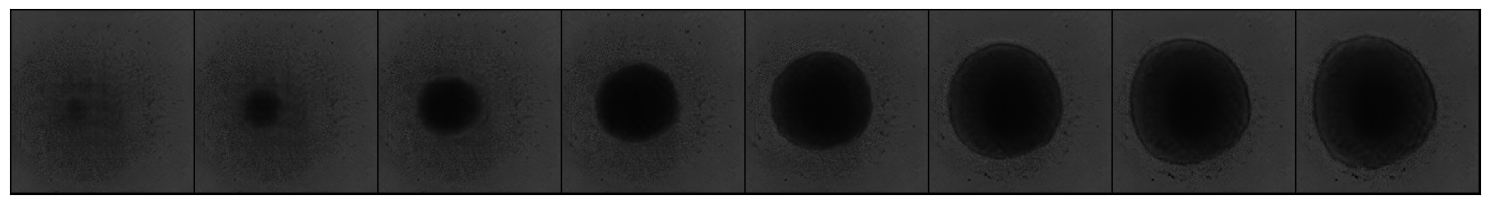

In [26]:
# Doing the projection
pl.figure(1, figsize=(15, 15))
plt = pl.subplot(111)
torch_imshow(Xinter_grid)
plt.set_xticks([])
plt.set_yticks([])
pl.tight_layout()
#pl.savefig(f'{figdir}/randomsamples.png', dpi=300)